In [5]:
import os
import datetime

import pandas as pd
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

from sklearn.decomposition import PCA

from sklearn import svm
from sklearnex import patch_sklearn
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
project_path = "D:\\python\\mit-bih_ecg_recognition\\"

In [36]:
RATIO = 0.3

In [24]:
#log_dir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = "ecg_model.h5"

In [23]:
# Wavelet denoising preprocessing
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

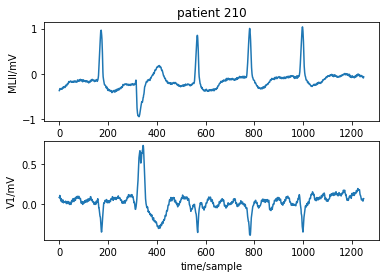

In [45]:
rec = 210
record = wfdb.rdrecord(f'database/{rec}', sampfrom=300, sampto=1550)
#record = wfdb.rdrecord(f'database/{rec}')
annotation = wfdb.rdann(f'database/{rec}', 'atr')
symbol = annotation.symbol
values, counts = np.unique(symbol, return_counts=True)
dataframe_sub = pd.DataFrame({'symbols':values, 'values':counts, 'patient':[rec]*len(counts)})
wfdb.plot_wfdb(record=record, title='patient 210') 

In [52]:
annotation.__dict__

{'record_name': '210',
 'extension': 'atr',
 'sample': array([    13,     57,    250, ..., 649513, 649758, 649962]),
 'symbol': ['+',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'F',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'V',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'

In [49]:
annotation.sample

array([    13,     57,    250, ..., 649513, 649758, 649962])

In [50]:
annotation.sample.shape

(2685,)

In [47]:
#rdata = denoise(data=record)

In [30]:
display(record.__dict__)

{'record_name': '210',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['89 M 2461 694 x1', 'None', 'The PVCs are multiform.'],
 'sig_name': ['MLII', 'V1'],
 'p_signal': array([[-0.065,  0.135],
        [-0.065,  0.135],
        [-0.065,  0.135],
        ...,
        [-0.305,  0.075],
        [-0.3  ,  0.1  ],
        [ 0.   ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['210.dat', '210.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [1011, 1051],
 'checksum': [19348, -30580],
 'block_size': [0, 0]}

In [57]:
noise_removed = denoise(record.p_signal.flatten())

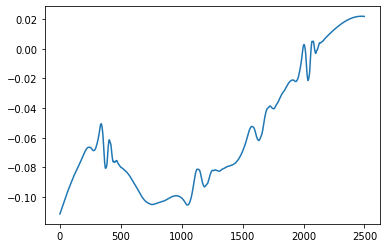

In [58]:
fig, ax = plt.subplots()
ax.plot(noise_removed)

In [31]:
# Read ECG data and corresponding labels, and perform wavelet denoising on the data
def getDataSet(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']

    # Read ECG data records
    print("reading " + number + " ECG data...")
    record = wfdb.rdrecord('database/' + number, channel_names=['MLII'])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position of the R wave and the corresponding label in the ECG data record
    annotation = wfdb.rdann('database/' + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Remove unstable data before and after
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end

    # Because only five ECG types of NAVLR are selected, 
    # the data with a specific label that is required in this record should be selected, and the points with the remaining labels should be discarded.
    # X_data intercepts data points of length 300 before and after the R wave
    # Y_data converts NAVLR to 01234 in order
    while i < j:
        try:
            lable = ecgClassSet.index(Rclass[i])
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            i += 1
    return

In [32]:
# Load the dataset and preprocess
def loadData():
    numberSet = ['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
                 '116', '117', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208',
                 '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
                 '231', '232', '233', '234']
    dataSet = []
    lableSet = []
    for n in numberSet:
        getDataSet(n, dataSet, lableSet)

    # Convert numpy arrays, shuffle the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]

    # Test set and its label set
    shuffle_index = np.random.permutation(len(X))
    test_length = int(RATIO * len(shuffle_index))
    test_index = shuffle_index[:test_length]
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]
    return X_train, Y_train, X_test, Y_test


In [33]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, 4 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        # The first pooling layer, max pooling, 4 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolutional layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # Second pooling layer, max pooling, 4 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolutional layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        # The third pooling layer, average pooling, 4 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # Fourth convolutional layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # Leveling layer, convenient for fully connected layer processing
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer, dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [34]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # drawing
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [37]:
X_train, Y_train, X_test, Y_test = loadData()

reading 100 ECG data...
reading 101 ECG data...
reading 103 ECG data...
reading 105 ECG data...
reading 106 ECG data...
reading 107 ECG data...
reading 108 ECG data...
reading 109 ECG data...
reading 111 ECG data...
reading 112 ECG data...
reading 113 ECG data...
reading 114 ECG data...
reading 115 ECG data...
reading 116 ECG data...
reading 117 ECG data...
reading 119 ECG data...
reading 121 ECG data...
reading 122 ECG data...
reading 123 ECG data...
reading 124 ECG data...
reading 200 ECG data...
reading 201 ECG data...
reading 202 ECG data...
reading 203 ECG data...
reading 205 ECG data...
reading 208 ECG data...
reading 210 ECG data...
reading 212 ECG data...
reading 213 ECG data...
reading 214 ECG data...
reading 215 ECG data...
reading 217 ECG data...
reading 219 ECG data...
reading 220 ECG data...
reading 221 ECG data...
reading 222 ECG data...
reading 223 ECG data...
reading 228 ECG data...
reading 230 ECG data...
reading 231 ECG data...
reading 232 ECG data...
reading 233 ECG 

In [38]:
X_train.shape

(64535, 300, 1)

In [12]:
model = buildModel()

In [13]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 300, 4)            88        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 4)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 16)           1488      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 75, 32)            12832     
                                                                 
 average_pooling1d (AverageP  (None, 38, 32)           0

In [15]:
model.fit(X_train, Y_train, epochs=30,
                  batch_size=128,
                  validation_split=RATIO)
                  #callbacks=[tensorboard_callback])

Epoch 1/30
353/353 [==============================] - 6s 8ms/step - loss: 0.2440 - accuracy: 0.9312 - val_loss: 0.0787 - val_accuracy: 0.9803
Epoch 2/30
353/353 [==============================] - 2s 6ms/step - loss: 0.0688 - accuracy: 0.9829 - val_loss: 0.0549 - val_accuracy: 0.9837
Epoch 3/30
353/353 [==============================] - 2s 6ms/step - loss: 0.0471 - accuracy: 0.9877 - val_loss: 0.0454 - val_accuracy: 0.9889
Epoch 4/30
353/353 [==============================] - 2s 6ms/step - loss: 0.0379 - accuracy: 0.9897 - val_loss: 0.0337 - val_accuracy: 0.9916
Epoch 5/30
353/353 [==============================] - 2s 6ms/step - loss: 0.0292 - accuracy: 0.9921 - val_loss: 0.0313 - val_accuracy: 0.9920
Epoch 6/30
353/353 [==============================] - 2s 6ms/step - loss: 0.0246 - accuracy: 0.9929 - val_loss: 0.0296 - val_accuracy: 0.9926
Epoch 7/30
353/353 [==============================] - 2s 6ms/step - loss: 0.0236 - accuracy: 0.9935 - val_loss: 0.0289 - val_accuracy: 0.9928
Epoch 

In [16]:
Y_pred = model.predict(X_test)

In [17]:
confusion_matrix(Y_test, np.argmax(Y_pred, axis=1))

array([[21431,    40,    18,     1,     2],
       [   36,   502,     2,     0,     1],
       [   37,     1,  2080,     1,     0],
       [    2,     1,     2,  1991,     0],
       [    4,     1,     0,     0,  1504]], dtype=int64)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21492
         1.0       0.92      0.93      0.92       541
         2.0       0.99      0.98      0.99      2119
         3.0       1.00      1.00      1.00      1996
         4.0       1.00      1.00      1.00      1509

    accuracy                           0.99     27657
   macro avg       0.98      0.98      0.98     27657
weighted avg       0.99      0.99      0.99     27657



In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_test, np.argmax(Y_pred, axis=1))

0.9946125754781792

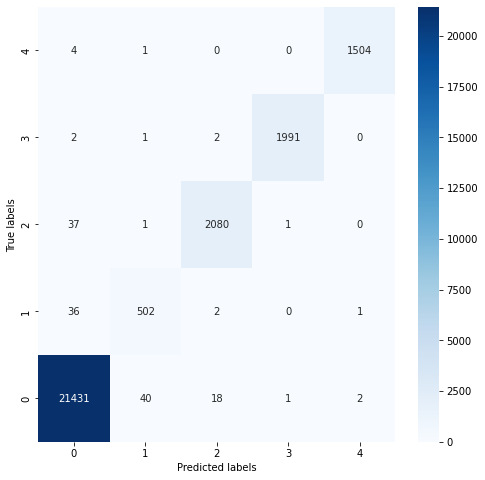

In [20]:
plotHeatMap(Y_test, np.argmax(Y_pred, axis=1))

In [39]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))




In [40]:
d2_train_dataset.shape

(64535, 300)

In [44]:


RBF = svm.SVC(kernel="rbf", C=1, gamma =1, decision_function_shape='ovo').fit(d2_train_dataset, Y_train)

In [46]:
nsamples, nx, ny = X_test.shape
test = X_test.reshape((nsamples,nx*ny))

In [47]:
rbf_pred = RBF.predict(test)


In [48]:
RBF.score(test, Y_test)

0.9458726543009003

In [50]:
confusion_matrix(Y_test, rbf_pred)

array([[21489,     2,     0,     1,     0],
       [  150,   390,     0,     0,     1],
       [ 1065,     0,  1054,     0,     0],
       [  180,     0,     0,  1816,     0],
       [   98,     0,     0,     0,  1411]], dtype=int64)

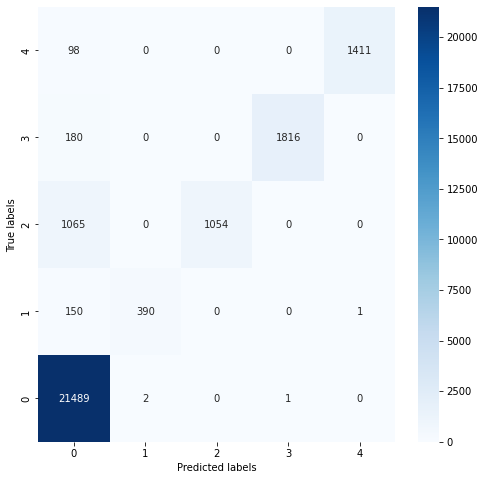

In [51]:
plotHeatMap(Y_test, rbf_pred) #adjust to make the representation correct 

In [54]:
print(classification_report(Y_test, rbf_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     21492
         1.0       0.99      0.72      0.84       541
         2.0       1.00      0.50      0.66      2119
         3.0       1.00      0.91      0.95      1996
         4.0       1.00      0.94      0.97      1509

    accuracy                           0.95     27657
   macro avg       0.99      0.81      0.88     27657
weighted avg       0.95      0.95      0.94     27657



In [21]:
#load model 

In [22]:
#load data 

In [23]:
#use model to poredict 